<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/6_feature_extraction_using_sparse_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction using Sparse Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Sparse Autoencoders 

Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer.

For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations.
As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).

Let's load MNIST dataset.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

Here is a simple stacked autoencoder for Fashion MNIST:

In [0]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# split the autoencoder model into two submodels: the encoder and the decoder.
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784  
    keras.layers.Dense(100, activation='selu'),    
    keras.layers.Dense(30, activation='sigmoid')
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),  
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

simple_autoencoder = keras.models.Sequential([simple_encoder, simple_decoder])
simple_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = simple_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 169us/sample - loss: 0.4332 - rounded_accuracy: 0.7944 - val_loss: 0.3777 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 7s 131us/sample - loss: 0.3614 - rounded_accuracy: 0.8667 - val_loss: 0.3511 - val_rounded_accuracy: 0.8785
Epoch 3/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.3403 - rounded_accuracy: 0.8860 - val_loss: 0.3360 - val_rounded_accuracy: 0.8898
Epoch 4/10
55000/55000 [==============================] - 7s 131us/sample - loss: 0.3280 - rounded_accuracy: 0.8962 - val_loss: 0.3256 - val_rounded_accuracy: 0.9006
Epoch 5/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3215 - val_rounded_accuracy: 0.9018
Epoch 6/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.3178 - rounded_accuracy: 0.9037 - val

In [6]:
simple_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [7]:
simple_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. 

Let’s plot a few images from the validation set, as well as their reconstructions:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

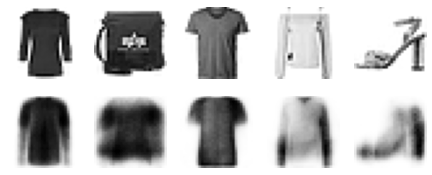

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

show_reconstructions(simple_autoencoder)

Let's create a couple functions to print nice activation histograms:

In [0]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [0]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

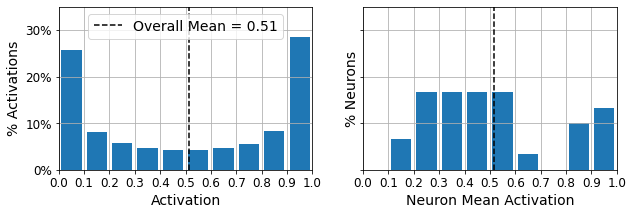

In [13]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some ℓ1 regularization to the coding layer’s activations (the decoder is just a regular decoder).

Now let's add $\ell_1$ regularization to the coding layer:

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# split the autoencoder model into two submodels: the encoder and the decoder.
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784    
    keras.layers.Dense(100, activation='selu'),    
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
    # Alternatively, you could add activity_regularizer=keras.regularizers.l1(1e-3) to the previous layer.
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),  
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

sparse_l1_autoencoder = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = sparse_l1_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 156us/sample - loss: 0.4311 - rounded_accuracy: 0.8128 - val_loss: 0.3809 - val_rounded_accuracy: 0.8564
Epoch 2/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.3691 - rounded_accuracy: 0.8687 - val_loss: 0.3639 - val_rounded_accuracy: 0.8750
Epoch 3/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.3546 - rounded_accuracy: 0.8799 - val_loss: 0.3504 - val_rounded_accuracy: 0.8859
Epoch 4/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3437 - val_rounded_accuracy: 0.8917
Epoch 5/10
55000/55000 [==============================] - 8s 144us/sample - loss: 0.3373 - rounded_accuracy: 0.8922 - val_loss: 0.3361 - val_rounded_accuracy: 0.8946
Epoch 6/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.3319 - rounded_accuracy: 0.8971 - val

This ActivityRegularization layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). Equivalently, you could remove the ActivityRegularization layer and set activity_regularizer=keras.regularizers.l1(1e-3) in the previous
layer. This penalty will encourage the neural network to produce codings close to 0, but since it will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. 

Using the ℓ1 norm rather than the ℓ2 norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

In [15]:
sparse_l1_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
_________________________________________________________________
activity_regularization (Act (None, 300)               0         
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________


In [16]:
sparse_l1_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 109,284
Trainable params: 109,284
Non-trainable params: 0
_________________________________________________________________


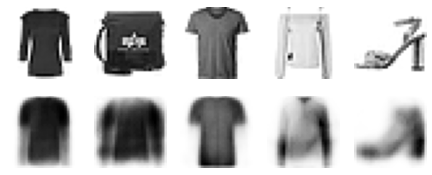

In [17]:
show_reconstructions(sparse_l1_autoencoder)

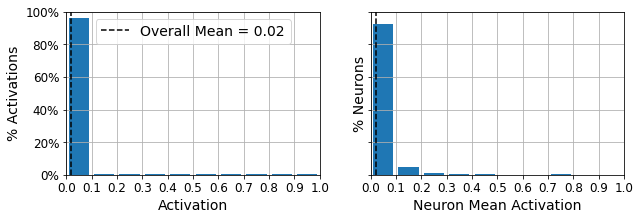

In [18]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

## Sparse autoencoder based on the KL divergence

Once we have the mean activation per neuron, we want to penalize the neurons that are too active, or not active enough, by adding a sparsity loss to the cost function. 

For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1, it must be penalized to activate less. One approach could be simply adding the squared error (0.3 – 0.1)2 to the cost function, but in practice a better approach is to use the Kullback–Leibler (KL) divergence which has much stronger gradients than the mean squared error.

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

(0.0, 1.0, 0.0, 0.95)

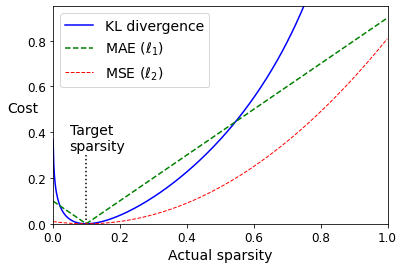

In [19]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

Once we have computed the sparsity loss for each neuron in the coding layer, we sum up these losses and add the result to the cost function. In order to control the relative importance of the sparsity loss and the reconstruction loss, we can multiply the sparsity loss by a sparsity weight hyperparameter. 

If this weight is too high, the model will stick closely to the target sparsity, but it may not reconstruct the inputs properly, making the model useless. Conversely, if it is too low, the model will mostly ignore the sparsity objective and will not learn any interesting features.

We now have all we need to implement a sparse autoencoder based on the KL divergence.

First, let’s create a custom regularizer to apply KL divergence regularization:

In [0]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):

  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target

  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1. - self.target, 1. - mean_activities))

Now we can build the sparse autoencoder, using the KLDivergenceRegularizer for the coding layer’s activations:

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
# split the autoencoder model into two submodels: the encoder and the decoder.
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784    
    keras.layers.Dense(100, activation='selu'),    
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),  
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

sparse_kl_autoencoder = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = sparse_kl_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 180us/sample - loss: 0.4152 - rounded_accuracy: 0.8119 - val_loss: 0.3717 - val_rounded_accuracy: 0.8562
Epoch 2/10
55000/55000 [==============================] - 9s 168us/sample - loss: 0.3534 - rounded_accuracy: 0.8759 - val_loss: 0.3445 - val_rounded_accuracy: 0.8849
Epoch 3/10
55000/55000 [==============================] - 9s 167us/sample - loss: 0.3342 - rounded_accuracy: 0.8917 - val_loss: 0.3295 - val_rounded_accuracy: 0.8976
Epoch 4/10
55000/55000 [==============================] - 9s 168us/sample - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3214 - val_rounded_accuracy: 0.9037
Epoch 5/10
55000/55000 [==============================] - 9s 167us/sample - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9082
Epoch 6/10
55000/55000 [==============================] - 9s 169us/sample - loss: 0.3134 - rounded_accuracy: 0.9093 - va

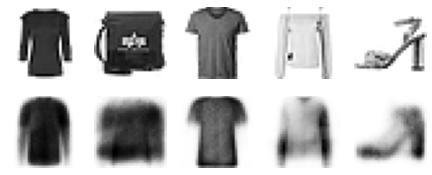

In [25]:
show_reconstructions(sparse_kl_autoencoder)

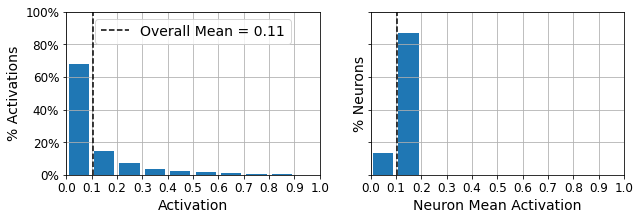

In [26]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

After training this sparse autoencoder on Fashion MNIST, the activations of the neurons in the coding layer are mostly close to 0 (about 70% of all activations are lower than 0.1), and all neurons have a mean activation around 0.1 (about 90% of all neurons have a mean activation between 0.1 and 0.2).